Binary classification between subjects with ICD10 cat 10 and those whithout!

Based on copy 3

### \\\ Currently used ///

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, random_split

# sklearn functions
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

In [5]:
torch.__version__

'1.0.0'

In [6]:
# use multiple GPUs
gpu = 7
multi_gpus = None#[0, 1, 2]
b = 12
zero_one_normalize = False
dtype = np.float64

In [7]:
# load mask
mask = None

In [8]:
table = "/analysis/ritter/projects/UKbiobank/Eitel_ICD/tables/participants_transMRI_T1-ICD10_G_binary-under.csv"

In [9]:
# load dataset and show first 5 rows
df = pd.read_csv(table)
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
0,0,1100042,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100042,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,0YY,1NN,1NN,1NN,9Na,9Na
1,1,1100675,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1100675,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,9else,1NN,0YY,9else,1NN,9else,9Na,9Na
2,2,1180478,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1180478,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,0YY,1NN,2YN,0YY,1NN,0YY,9Na,9Na
3,3,1112124,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1112124,20252_2_0,20253_2_0,20249_2_0,Male,[],...,0None,9else,0YY,0YY,0YY,9else,1NN,1NN,9Na,9Na
4,4,1148079,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1148079,20252_2_0,20253_2_0,20249_2_0,Female,[],...,3SitY,3NY,0YY,3NY,0YY,3NY,1NN,1NN,9Na,9Na


In [10]:
# shuffle the dataset
df = df.sample(frac=1) # NOTE: use all!
df.head()

,Unnamed: 0,PTID,file_path,T2,Encoded anonymised participant ID,T1 structural brain images - NIFTI Index: 2.0,T2 FLAIR structural brain images - NIFTI Index: 2.0,Functional brain images - task - NIFTI Index: 2.0,Sex,ICD10_F_cat,...,Illness2Years2,MoodSwings_diff,Sensitivity_diff,Nervous_diff,Worrier_diff,TenseHighlyStung_diff,Loneliness_diff,RiskTaking_diff,Happiness_diff,FamilyRelation_diff
650,650,1150371,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1150371,20252_2_0,20253_2_0,20249_2_0,Male,[],...,"4SitR,5DocR",1NN,0YY,1NN,9else,1NN,1NN,1NN,9Na,9Na
105,105,1125418,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1125418,20252_2_0,20253_2_0,NaN,Female,[],...,4SitR,2YN,1NN,1NN,2YN,1NN,1NN,1NN,9Na,9Na
735,735,1185799,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1185799,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,1NN,1NN,1NN,0YY,1NN,1NN,1NN,MH.MH,VH.MH
689,689,1082021,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,1082021,20252_2_0,20253_2_0,20249_2_0,Female,[],...,0None,0YY,3NY,1NN,3NY,1NN,1NN,1NN,VH.MH,EH.VH
1229,1229,1188676,/analysis/ritter/data/UKbiobank/UKBiobank_BIDS...,[],1188676,20252_2_0,NaN,20249_2_0,Female,[],...,"5DocR,1FD",0YY,2YN,1NN,1NN,1NN,1NN,2YN,9Na,9Na


In [11]:
class UKBGDataset(Dataset):
    def __init__(self, dataframe, transform=None, mask=None, z_factor=None):
        self.df = dataframe
        self.transform = transform
        self.mask = mask
        self.z_factor = z_factor
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if isinstance(idx, torch.FloatTensor):
            idx = idx.item()
        idx = int(idx)
        
        path = self.df.iloc[idx]['file_path']
        image = load_nifti(path, mask=self.mask, z_factor=self.z_factor)
        #label = self.df.iloc[idx]['ICD10_G_bool']
        #label = torch.FloatTensor([int(label)])
        
        label = self.df.iloc[idx]['Sex']
        label = torch.FloatTensor([int(label == "Male")])
        
        if self.transform:
            image = self.transform(image)
        
        sample = {
            "image" : image,
            "label" : label
         }
        return sample

In [12]:
augmentations = [SagittalFlip()]

In [13]:
intensity = IntensityRescale(masked=False)
input_trans = transforms.Compose(augmentations + [intensity, ToTensor()])
#input_trans = transforms.Compose([ToTensor()])

In [14]:
ukb_data = UKBGDataset(df, transform=input_trans, mask=mask)#, z_factor=0.5)

In [15]:
len(ukb_data)

1854

In [16]:
# split train/test
train_df = df.sample(frac=0.8, random_state=32)
test_df = df[~df["PTID"].isin(train_df["PTID"])]
print(len(test_df))

371


In [17]:
sample = ukb_data[3]
img = sample["image"]

In [18]:
img.shape

torch.Size([1, 182, 218, 182])

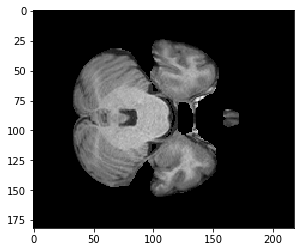

In [19]:
plt.imshow(img[0][:,:,40], cmap='gray')

In [20]:
sample["label"]

tensor([0.])

# Define the classifier

In [21]:
class PatchIndividualFilters3D(Module):
    def __init__(self, input_dim, filter_shape, patch_shape, num_local_filter_in, num_local_filter_out, debug=0):
        super(PatchIndividualFilters3D, self).__init__()
        self.input_dim = input_dim  # expects it to be a 3D vector
        self.filter_shape = filter_shape
        self.patch_shape = patch_shape
        self.num_local_filter_out = num_local_filter_out
        self.num_local_filter_in = num_local_filter_in

        # calc padding and num_patches
        self.padding_dim = [0] * len(self.input_dim) * 2
        # initialize all local convs with weight & co
        self.num_patches, self.num_patches_per_dim = self.calc_pad_dim_num_patches()

        self.conv_dict = {}
        for patch in range(self.num_patches):
            # initialize convolution object
            self.add_module("conv_{}".format(patch),
                            nn.Conv3d(self.num_local_filter_in, self.num_local_filter_out, self.filter_shape, stride=1))
            # initialize activation object
            self.add_module("activ_{}".format(patch),
                            nn.ELU())
            

        self.grads = {}
        self.debug = debug

    def save_grad(self, name):

        def hook(grad):
            self.grads[name] = grad

        return hook

    def calc_pad_dim_num_patches(self):
        # initialize
        num_patches = 1
        num_patches_per_dim = [0] * len(self.input_dim)

        # check if patch_shape fits input dimension
        for idx, dim in enumerate(self.patch_shape):
            tmp_remain = self.input_dim[idx] % dim
            tmp_division = self.input_dim[idx] // dim
            if tmp_remain != 0:
                # how much we need to add sch that patch_shape fits perfectly
                self.padding_dim[idx * 2] = dim - tmp_remain
                tmp_division += 1
            num_patches_per_dim[idx] = tmp_division
            num_patches = num_patches * tmp_division
        return num_patches, num_patches_per_dim

    def pad_to_batch_size(self, input):
        # expects input to be a 5D vector!

        # pad input
        if sum(self.padding_dim):
            # add batch and channel dimension, each twice, to padding dim
            pad_dim = [0, 0, 0, 0] + self.padding_dim

            # use constant pad (caution: last dimension first!)
            input = torch.nn.functional.pad(input, pad_dim[::-1], mode='constant', value=0)

        if self.debug:
            input.register_hook(self.save_grad("post_padding"))

        return input

    def split_5d(self, input):
        # get batch size of input
        bs = input.shape[0]
        # initialize
        splits = []
        # loop over batch and filter and split each "input"
        for batch in range(bs):
            splits_filter = []
            for filter in range(self.num_local_filter_in):
                feature_map_in = input[batch, filter]
                # get chunks back from feature map ("input")
                t = self.get_chunks(feature_map_in)
                # append chunk dimension
                t = [torch.unsqueeze(x, 0) for x in t]
                # cat along chunk dimension
                t = torch.cat(t, 0)
                # add to filter list
                splits_filter += [t]
            # append filter dimension
            splits_filter = [torch.unsqueeze(x, 0) for x in splits_filter]
            # cat along filter dimension
            splits_filter = torch.cat(splits_filter, 0)
            splits += [splits_filter]
        # append batch dimension
        splits = [torch.unsqueeze(x, 0) for x in splits]
        # finally cat along that dimension
        splits = torch.cat(splits, 0)

        if self.debug:
            input.register_hook(self.save_grad("post_reshape"))

        return splits, bs  # a 6D vector

    def get_chunks(self, ddd_input):
        ddd_input_shape = ddd_input.shape
        tns = [ddd_input]
        # for every dimension in 3d input we split according to dimension and number of desired patches
        for id, dim in enumerate(ddd_input_shape):
            tns_tmp = []
            for tnsr in tns:
                # determine how to split the tensor.
                # Example:
                # dimension is 4: 2 batches desired in that dimension -> split dimension in [2,2]
                # dimension is 4: 4 batches desired in that dimension -> split dimension in [1,1,1,1]
                dim_x_split_size = [int(dim / self.num_patches_per_dim[id])] * self.num_patches_per_dim[id]
                # print("dim: " + str(dim))
                # print("num_patches: " + str(self.num_patches_per_dim))
                # print("dim_split_size: " + str(dim_x_split_size))
                tmp = torch.split(tnsr, dim_x_split_size, id)
                tns_tmp += list(tmp)
            tns = tns_tmp
        return tns

    def call_conv(self, idx, patch):

        if self.debug:
            patch.register_hook(self.save_grad("pre_convol_{}".format(idx)))

        # apply convolution
        c_res = getattr(self, "conv_{}".format(idx))(patch)
        # apply activation
        c_res = getattr(self, "activ_{}".format(idx))(c_res)

        if self.debug:
            c_res.register_hook(self.save_grad("post_conv_{}".format(idx)))

        # add 6th dimension at 2. place for later cat
        c_res = c_res.unsqueeze(2)

        if self.debug:
            c_res.register_hook(self.save_grad("post_usqz_c_{}".format(idx)))

        return c_res

    def forward(self, input):

        # set hook to save gradient in debug mode
        if self.debug:
            input.register_hook(self.save_grad("backward_out"))

        # do reshape here!
        input = self.pad_to_batch_size(input)

        # reshape
        input, bs = self.split_5d(input)

        patch_out = []
        for idx in range(self.num_patches):
            # get patch
            patch = input[:, :, idx]  # get each patch (3nd Dimension of 6D vector)
            # do separate convolutions with each 5D vector!
            patch_out += [self.call_conv(idx, patch)]

        # concat to get 6D vector back
        out = torch.cat(patch_out, dim=2)

        # # put together
        # f_out = []
        # feature_out_dim = out.shape[-3:]
        # for filter in range(self.num_local_filter_out):
        #     filter_patch = []
        #     for patch in range(self.num_patches):
        #         y = out[patch, :, filter]
        #         filter_patch.append(y)
        #     z = torch.cat(filter_patch)
        #     z = z.view((bs,) + tuple([x * self.num_patches_per_dim[id] for id, x in enumerate(feature_out_dim)]))
        #     f_out.append(z)
        # out = torch.cat(f_out).unsqueeze(0)
        # out = out.view((bs, self.num_local_filter_out) + tuple([x * self.num_patches_per_dim[id] for id, x in enumerate(feature_out_dim)]))

        if self.debug:
            out.register_hook(self.save_grad("backward_in"))

        return out

In [22]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_3 = nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=4, stride=3, padding=0)

        self.pif = PatchIndividualFilters3D([15,19,15],
                                            filter_shape=(3,3,3),
                                            patch_shape=(5,5,5),
                                            num_local_filter_in=64,
                                            num_local_filter_out=8,
                                            debug=False)

        # 4, 64, 1, 2, 1
        self.classifier_scratch = nn.Sequential(
            nn.Linear(7776, 100),
            nn.Linear(100, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        #h = F.dropout3d(self.pool_4(x), p=self.drp_rate)
        #if print_size:
        #    print(h.shape)
    
        h = self.pif(x)
    
        return h

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [23]:
if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)

In [24]:
print("Trainable model parameters: {}".format(count_parameters(net)))

Trainable model parameters: 1348665


# Training

In [25]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    #for train_idx, val_idx in kf.split(data):#, df["label"]):
    for trial in range(10):
        print("Starting trial {}".format(trial))

        # add current fold number to model checkpoint path
        if callbacks is not None:
            for idx, callback in enumerate(callbacks):
                if isinstance(callback, ModelCheckpoint):
                    if initial_prepend is None:
                        initial_prepend = callbacks[idx].prepend
                    callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
        fold += 1

        # restart model
        del net
        net = SixtyFourNet().cuda(gpu)
        
        # reset hyperparameters
        lr = 1e-4
        wd = 1e-5
        criterion = nn.BCEWithLogitsLoss().cuda(gpu)
        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
        #optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=wd, momentum=True)
        
        #sched = optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=12)
        #sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=5)
        
        # split train/validation
        train_df = data.sample(frac=0.8, random_state=32)
        val_df = data[~data["PTID"].isin(train_df["PTID"])]

        if zero_one_normalize:
            intensity = IntensityRescale()
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
        else:
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([ToTensor()]), mask=mask)
        
        train_loader = DataLoader(
            ukb_data_train, batch_size=b, shuffle=True, num_workers=4
        )

        val_loader = DataLoader(
            ukb_data_val, batch_size=2, shuffle=True, num_workers=2
        )

        trainer = Trainer(
            net,
            criterion,
            optimizer,
            metrics=metrics,
            callbacks=callbacks,
            device=gpu,
            #scheduler=sched,
        )
        # train model and store results
        net, report = trainer.train_model(
            train_loader,
            val_loader,
            num_epochs=num_epochs,
            show_train_steps=30,
            show_validation_epochs=1,
        )
        # append validation score of the retain metric
        if isinstance(retain_metric, str):
            fold_metric.append(report["val_metrics"][retain_metric][-1])
        else:
            fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])

        models.append(net)
        print("Finished fold.")

        # visualize result
        trainer.visualize_training(report, metrics)
        trainer.evaluate_model(val_loader, gpu)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    return fold_metric, models


In [26]:
num_epochs = 200
min_iters = 3
ignore_epochs = 5
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [27]:
r = 0

In [28]:
#output_dir = "/analysis/fabiane/models/MS/pretrained/from_keras/pytorch_finetuned/hdf5"
# ModelCheckpoint(path=output_dir,
                             #prepend="repeat_{}".format(r),
                             #store_best=True,
                             #ignore_before=ignore_epochs,
                             #retain_metric=retain_metric),
callbacks = [EarlyStopping(patience=8, ignore_before=ignore_epochs, retain_metric="loss", mode='min')]


Starting trial 0
[0,    30] loss: 1.80518
[0,    60] loss: 0.73202
[0,    90] loss: 0.74489
Time elapsed: 0h:3m:44s
train accuracy_score: 54.22 %
train balanced_accuracy: 53.75 %
val accuracy_score: 63.30 %
val balanced_accuracy: 62.74 %
Val loss: 0.632601
[1,    30] loss: 0.70600
[1,    60] loss: 0.74269
[1,    90] loss: 0.67483
Time elapsed: 0h:8m:36s
train accuracy_score: 57.17 %
train balanced_accuracy: 56.58 %
val accuracy_score: 50.84 %
val balanced_accuracy: 50.00 %
Val loss: 0.804831
[2,    30] loss: 0.68329
[2,    60] loss: 0.67954
[2,    90] loss: 0.63127
Time elapsed: 0h:13m:24s
train accuracy_score: 60.20 %
train balanced_accuracy: 59.64 %
val accuracy_score: 53.20 %
val balanced_accuracy: 52.40 %
Val loss: 0.651250
[3,    30] loss: 0.59894
[3,    60] loss: 0.59895
[3,    90] loss: 0.61903
Time elapsed: 0h:18m:15s
train accuracy_score: 68.13 %
train balanced_accuracy: 67.70 %
val accuracy_score: 74.07 %
val balanced_accuracy: 74.48 %
Val loss: 0.515560
[4,    30] loss: 0.55

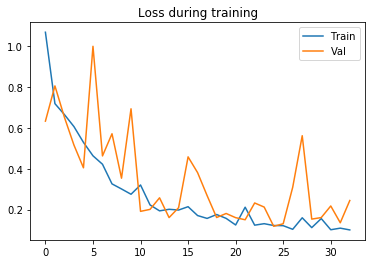

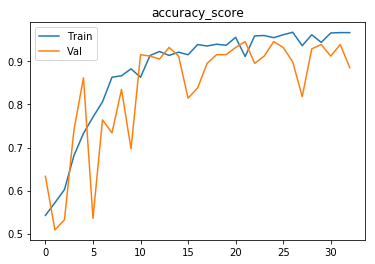

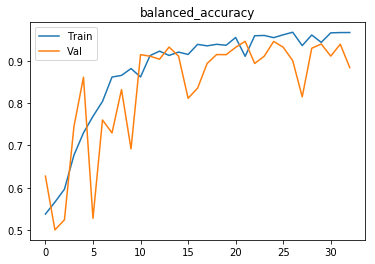

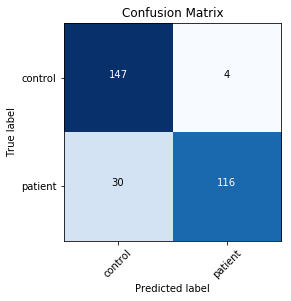

Starting trial 1
[0,    30] loss: 4.03114
[0,    60] loss: 0.88502
[0,    90] loss: 0.73879
Time elapsed: 0h:3m:47s
train accuracy_score: 53.12 %
train balanced_accuracy: 52.58 %
val accuracy_score: 57.58 %
val balanced_accuracy: 58.10 %
Val loss: 0.675881
[1,    30] loss: 0.74272
[1,    60] loss: 0.74317
[1,    90] loss: 0.69958
Time elapsed: 0h:8m:39s
train accuracy_score: 55.31 %
train balanced_accuracy: 54.51 %
val accuracy_score: 74.75 %
val balanced_accuracy: 74.44 %
Val loss: 0.638298
[2,    30] loss: 0.69585
[2,    60] loss: 0.76357
[2,    90] loss: 0.70683
Time elapsed: 0h:13m:25s
train accuracy_score: 56.07 %
train balanced_accuracy: 55.45 %
val accuracy_score: 51.52 %
val balanced_accuracy: 50.68 %
Val loss: 0.767319
[3,    30] loss: 0.71164
[3,    60] loss: 0.65728
[3,    90] loss: 0.70803
Time elapsed: 0h:18m:9s
train accuracy_score: 59.78 %
train balanced_accuracy: 59.32 %
val accuracy_score: 52.19 %
val balanced_accuracy: 51.38 %
Val loss: 0.685654
[4,    30] loss: 0.703

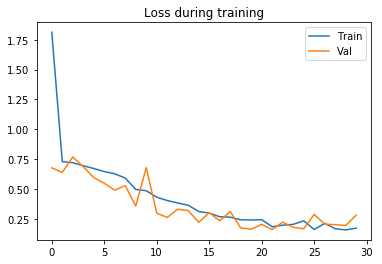

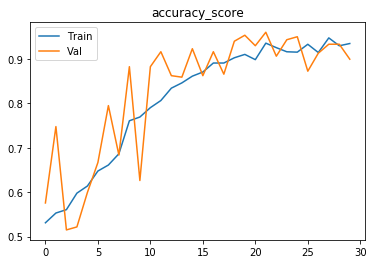

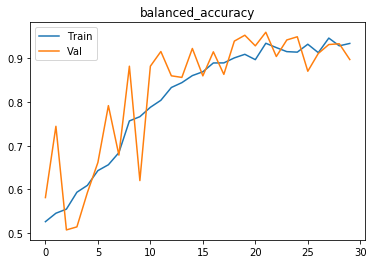

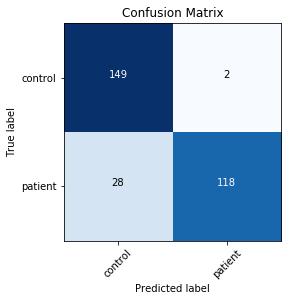

Starting trial 2
[0,    30] loss: 2.56374
[0,    60] loss: 0.74105
[0,    90] loss: 0.74442
Time elapsed: 0h:3m:50s
train accuracy_score: 51.60 %
train balanced_accuracy: 51.00 %
val accuracy_score: 50.84 %
val balanced_accuracy: 50.00 %
Val loss: 0.809158
[1,    30] loss: 0.81562
[1,    60] loss: 0.73189
[1,    90] loss: 0.75065
Time elapsed: 0h:8m:39s
train accuracy_score: 51.60 %
train balanced_accuracy: 51.01 %
val accuracy_score: 55.56 %
val balanced_accuracy: 56.29 %
Val loss: 0.652372
[2,    30] loss: 0.68394
[2,    60] loss: 0.72075
[2,    90] loss: 0.66607
Time elapsed: 0h:13m:25s
train accuracy_score: 59.61 %
train balanced_accuracy: 59.06 %
val accuracy_score: 53.87 %
val balanced_accuracy: 53.08 %
Val loss: 0.630343
[3,    30] loss: 0.68599
[3,    60] loss: 0.64947
[3,    90] loss: 0.62718
Time elapsed: 0h:18m:11s
train accuracy_score: 60.29 %
train balanced_accuracy: 59.59 %
val accuracy_score: 78.79 %
val balanced_accuracy: 78.52 %
Val loss: 0.528289
[4,    30] loss: 0.61

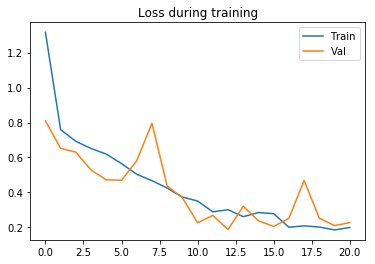

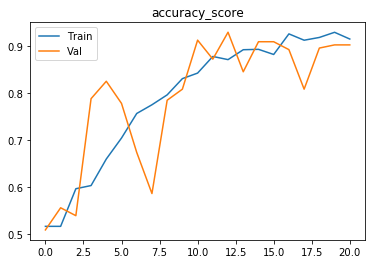

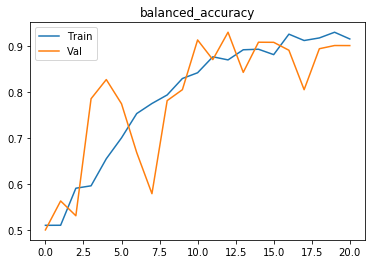

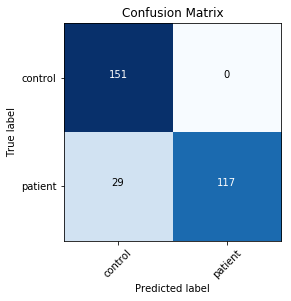

Starting trial 3
[0,    30] loss: 5.03089
[0,    60] loss: 0.80590
[0,    90] loss: 0.80245
Time elapsed: 0h:3m:40s
train accuracy_score: 52.02 %
train balanced_accuracy: 51.60 %
val accuracy_score: 49.16 %
val balanced_accuracy: 50.00 %
Val loss: 0.863713
[1,    30] loss: 0.77338
[1,    60] loss: 0.75417
[1,    90] loss: 0.70729
Time elapsed: 0h:8m:37s
train accuracy_score: 54.30 %
train balanced_accuracy: 53.61 %
val accuracy_score: 51.85 %
val balanced_accuracy: 51.03 %
Val loss: 0.679635
[2,    30] loss: 0.73150
[2,    60] loss: 0.72177
[2,    90] loss: 0.70947
Time elapsed: 0h:13m:25s
train accuracy_score: 54.05 %
train balanced_accuracy: 53.40 %
val accuracy_score: 51.18 %
val balanced_accuracy: 50.34 %
Val loss: 0.764813
[3,    30] loss: 0.72001
[3,    60] loss: 0.75911
[3,    90] loss: 0.73580
Time elapsed: 0h:18m:12s
train accuracy_score: 53.46 %
train balanced_accuracy: 52.85 %
val accuracy_score: 54.88 %
val balanced_accuracy: 54.15 %
Val loss: 0.657504
[4,    30] loss: 0.69

[34,    30] loss: 0.15211
[34,    60] loss: 0.23413
[34,    90] loss: 0.18137
Time elapsed: 2h:45m:6s
train accuracy_score: 93.25 %
train balanced_accuracy: 93.23 %
val accuracy_score: 87.88 %
val balanced_accuracy: 87.68 %
Val loss: 0.292909
[35,    30] loss: 0.24675
[35,    60] loss: 0.14397
[35,    90] loss: 0.22139
Time elapsed: 2h:49m:50s
train accuracy_score: 92.24 %
train balanced_accuracy: 92.25 %
val accuracy_score: 93.27 %
val balanced_accuracy: 93.34 %
Val loss: 0.169993
[36,    30] loss: 0.18200
[36,    60] loss: 0.12700
[36,    90] loss: 0.15879
Time elapsed: 2h:54m:41s
train accuracy_score: 94.01 %
train balanced_accuracy: 94.01 %
val accuracy_score: 91.25 %
val balanced_accuracy: 91.12 %
Val loss: 0.262643
[37,    30] loss: 0.14582
[37,    60] loss: 0.21302
[37,    90] loss: 0.13067
Time elapsed: 2h:59m:28s
train accuracy_score: 93.34 %
train balanced_accuracy: 93.27 %
val accuracy_score: 93.27 %
val balanced_accuracy: 93.35 %
Val loss: 0.151032
[38,    30] loss: 0.17634

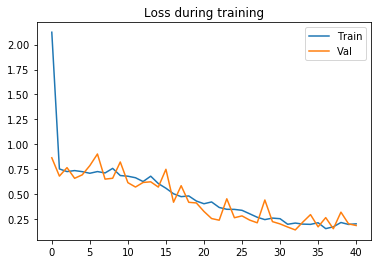

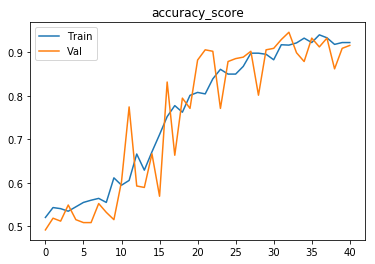

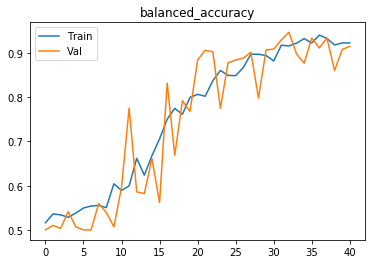

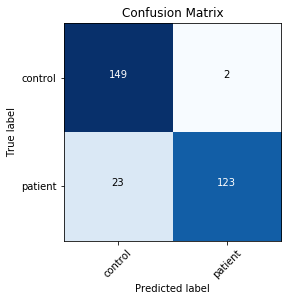

Starting trial 4
[0,    30] loss: 2.80096
[0,    60] loss: 0.88834
[0,    90] loss: 0.72571
Time elapsed: 0h:3m:48s
train accuracy_score: 51.94 %
train balanced_accuracy: 51.34 %
val accuracy_score: 56.57 %
val balanced_accuracy: 55.88 %
Val loss: 0.651967
[1,    30] loss: 0.85128
[1,    60] loss: 0.72287
[1,    90] loss: 0.73886
Time elapsed: 0h:8m:35s
train accuracy_score: 54.22 %
train balanced_accuracy: 53.69 %
val accuracy_score: 50.84 %
val balanced_accuracy: 50.00 %
Val loss: 0.782218
[2,    30] loss: 0.71260
[2,    60] loss: 0.67586
[2,    90] loss: 0.71791
Time elapsed: 0h:13m:25s
train accuracy_score: 57.59 %
train balanced_accuracy: 56.72 %
val accuracy_score: 55.22 %
val balanced_accuracy: 55.90 %
Val loss: 0.638565
[3,    30] loss: 0.71613
[3,    60] loss: 0.69573
[3,    90] loss: 0.68077
Time elapsed: 0h:18m:9s
train accuracy_score: 59.27 %
train balanced_accuracy: 58.85 %
val accuracy_score: 82.83 %
val balanced_accuracy: 82.69 %
Val loss: 0.544045
[4,    30] loss: 0.600

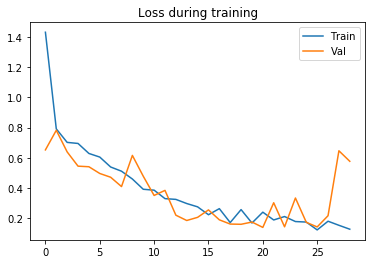

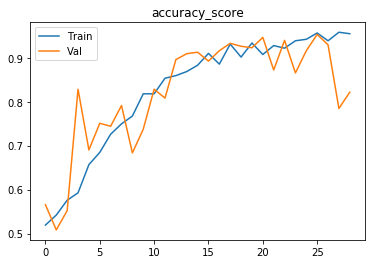

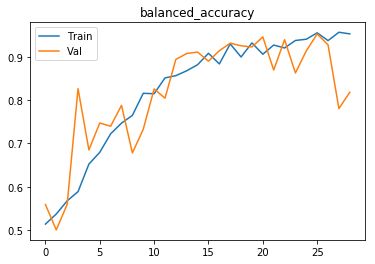

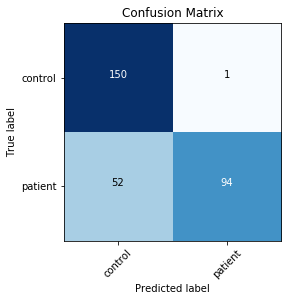

Starting trial 5
[0,    30] loss: 0.89920
[0,    60] loss: 0.66341
[0,    90] loss: 0.66669
Time elapsed: 0h:3m:47s
train accuracy_score: 60.03 %
train balanced_accuracy: 59.52 %
val accuracy_score: 79.46 %
val balanced_accuracy: 79.52 %
Val loss: 0.526091
[1,    30] loss: 0.57328
[1,    60] loss: 0.56122
[1,    90] loss: 0.48218
Time elapsed: 0h:8m:39s
train accuracy_score: 73.95 %
train balanced_accuracy: 73.51 %
val accuracy_score: 83.50 %
val balanced_accuracy: 83.66 %
Val loss: 0.399468
[2,    30] loss: 0.49507
[2,    60] loss: 0.55175
[2,    90] loss: 0.49665
Time elapsed: 0h:13m:31s
train accuracy_score: 76.05 %
train balanced_accuracy: 75.74 %
val accuracy_score: 87.88 %
val balanced_accuracy: 88.00 %
Val loss: 0.344325
[3,    30] loss: 0.49407
[3,    60] loss: 0.39701
[3,    90] loss: 0.35681
Time elapsed: 0h:18m:14s
train accuracy_score: 81.70 %
train balanced_accuracy: 81.55 %
val accuracy_score: 81.48 %
val balanced_accuracy: 81.19 %
Val loss: 0.362641
[4,    30] loss: 0.40

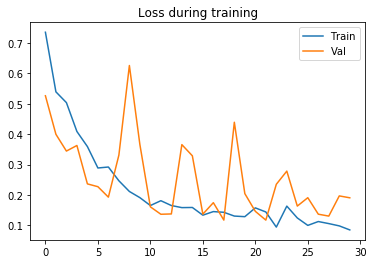

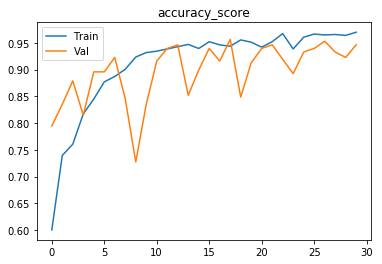

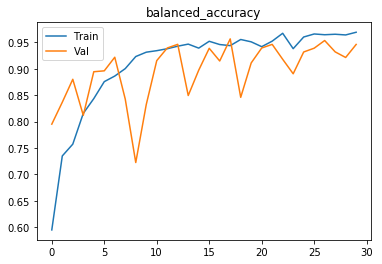

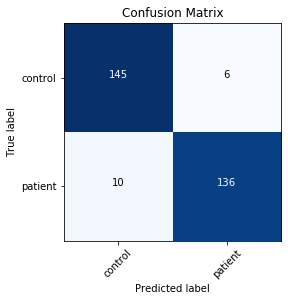

Starting trial 6
[0,    30] loss: 2.72559
[0,    60] loss: 0.80154
[0,    90] loss: 0.73587
Time elapsed: 0h:3m:43s
train accuracy_score: 51.35 %
train balanced_accuracy: 50.82 %
val accuracy_score: 50.17 %
val balanced_accuracy: 50.99 %
Val loss: 0.673294
[1,    30] loss: 0.75590
[1,    60] loss: 0.74010
[1,    90] loss: 0.70239
Time elapsed: 0h:8m:26s
train accuracy_score: 55.40 %
train balanced_accuracy: 54.93 %
val accuracy_score: 59.93 %
val balanced_accuracy: 60.60 %
Val loss: 0.627430
[2,    30] loss: 0.70678
[2,    60] loss: 0.70751
[2,    90] loss: 0.69129
Time elapsed: 0h:13m:13s
train accuracy_score: 58.85 %
train balanced_accuracy: 58.28 %
val accuracy_score: 63.64 %
val balanced_accuracy: 63.07 %
Val loss: 0.600549
[3,    30] loss: 0.60918
[3,    60] loss: 0.70021
[3,    90] loss: 0.66797
Time elapsed: 0h:18m:5s
train accuracy_score: 61.72 %
train balanced_accuracy: 61.05 %
val accuracy_score: 52.86 %
val balanced_accuracy: 52.07 %
Val loss: 0.647138
[4,    30] loss: 0.647

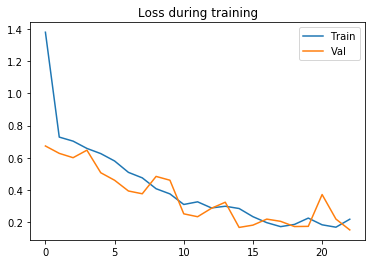

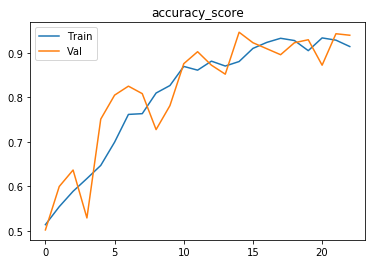

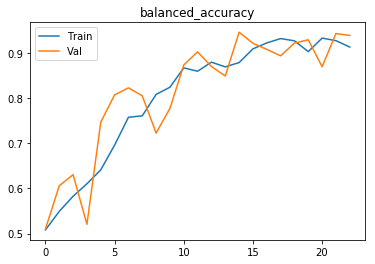

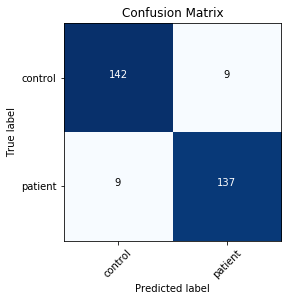

Starting trial 7
[0,    30] loss: 3.21936
[0,    60] loss: 0.82728
[0,    90] loss: 0.74660
Time elapsed: 0h:3m:52s
train accuracy_score: 53.29 %
train balanced_accuracy: 52.80 %
val accuracy_score: 54.21 %
val balanced_accuracy: 53.47 %
Val loss: 0.664882
[1,    30] loss: 0.72022
[1,    60] loss: 0.71611
[1,    90] loss: 0.71187
Time elapsed: 0h:8m:46s
train accuracy_score: 55.99 %
train balanced_accuracy: 55.18 %
val accuracy_score: 65.99 %
val balanced_accuracy: 66.47 %
Val loss: 0.622184
[2,    30] loss: 0.67520
[2,    60] loss: 0.70380
[2,    90] loss: 0.69555
Time elapsed: 0h:13m:31s
train accuracy_score: 57.50 %
train balanced_accuracy: 56.88 %
val accuracy_score: 52.19 %
val balanced_accuracy: 51.37 %
Val loss: 0.688442
[3,    30] loss: 0.70837
[3,    60] loss: 0.64220
[3,    90] loss: 0.62318
Time elapsed: 0h:18m:20s
train accuracy_score: 63.66 %
train balanced_accuracy: 63.22 %
val accuracy_score: 72.39 %
val balanced_accuracy: 71.95 %
Val loss: 0.551920
[4,    30] loss: 0.65

[34,    30] loss: 0.10569
[34,    60] loss: 0.15256
[34,    90] loss: 0.16115
Time elapsed: 2h:45m:22s
train accuracy_score: 95.53 %
train balanced_accuracy: 95.50 %
val accuracy_score: 91.58 %
val balanced_accuracy: 91.45 %
Val loss: 0.245565
[35,    30] loss: 0.11752
[35,    60] loss: 0.14996
[35,    90] loss: 0.13403
Time elapsed: 2h:50m:8s
train accuracy_score: 96.12 %
train balanced_accuracy: 96.10 %
val accuracy_score: 92.93 %
val balanced_accuracy: 92.88 %
Val loss: 0.160274
[36,    30] loss: 0.09334
[36,    60] loss: 0.07693
[36,    90] loss: 0.17221
Time elapsed: 2h:54m:54s
train accuracy_score: 96.04 %
train balanced_accuracy: 96.06 %
val accuracy_score: 90.24 %
val balanced_accuracy: 90.08 %
Val loss: 0.209134
[37,    30] loss: 0.07703
[37,    60] loss: 0.11840
[37,    90] loss: 0.14444
Time elapsed: 2h:59m:41s
train accuracy_score: 96.04 %
train balanced_accuracy: 96.01 %
val accuracy_score: 87.21 %
val balanced_accuracy: 87.01 %
Val loss: 0.427333
[38,    30] loss: 0.10759

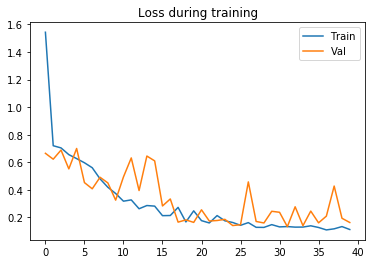

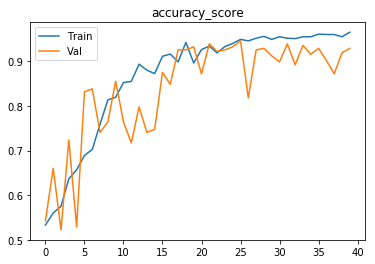

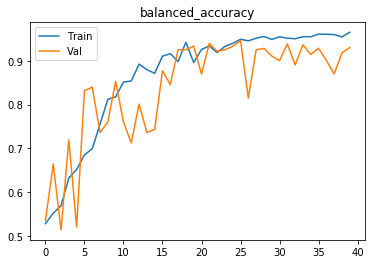

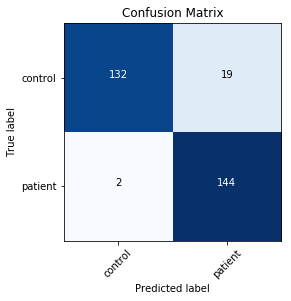

Starting trial 8
[0,    30] loss: 3.68605
[0,    60] loss: 0.79519
[0,    90] loss: 0.80068
Time elapsed: 0h:3m:49s
train accuracy_score: 53.54 %
train balanced_accuracy: 53.03 %
val accuracy_score: 51.52 %
val balanced_accuracy: 50.68 %
Val loss: 0.673763
[1,    30] loss: 0.78574
[1,    60] loss: 0.73895
[1,    90] loss: 0.71232
Time elapsed: 0h:8m:55s
train accuracy_score: 52.36 %
train balanced_accuracy: 51.74 %
val accuracy_score: 49.83 %
val balanced_accuracy: 50.66 %
Val loss: 0.675205
[2,    30] loss: 0.72564
[2,    60] loss: 0.69022
[2,    90] loss: 0.72035
Time elapsed: 0h:13m:44s
train accuracy_score: 55.99 %
train balanced_accuracy: 55.33 %
val accuracy_score: 53.20 %
val balanced_accuracy: 53.97 %
Val loss: 0.638283
[3,    30] loss: 0.67990
[3,    60] loss: 0.75274
[3,    90] loss: 0.67526
Time elapsed: 0h:19m:2s
train accuracy_score: 58.26 %
train balanced_accuracy: 57.96 %
val accuracy_score: 62.63 %
val balanced_accuracy: 63.23 %
Val loss: 0.609623
[4,    30] loss: 0.745

[34,    30] loss: 0.12621
[34,    60] loss: 0.11390
[34,    90] loss: 0.17515
Time elapsed: 2h:57m:28s
train accuracy_score: 94.86 %
train balanced_accuracy: 94.78 %
val accuracy_score: 94.95 %
val balanced_accuracy: 94.94 %
Val loss: 0.121188
[35,    30] loss: 0.14716
[35,    60] loss: 0.20534
[35,    90] loss: 0.15442
Time elapsed: 3h:2m:12s
train accuracy_score: 93.59 %
train balanced_accuracy: 93.54 %
val accuracy_score: 92.26 %
val balanced_accuracy: 92.18 %
Val loss: 0.156407
[36,    30] loss: 0.16165
[36,    60] loss: 0.22017
[36,    90] loss: 0.12753
Time elapsed: 3h:7m:0s
train accuracy_score: 93.51 %
train balanced_accuracy: 93.49 %
val accuracy_score: 93.60 %
val balanced_accuracy: 93.56 %
Val loss: 0.133674
[37,    30] loss: 0.15811
[37,    60] loss: 0.16111
[37,    90] loss: 0.12010
Time elapsed: 3h:12m:11s
train accuracy_score: 94.60 %
train balanced_accuracy: 94.57 %
val accuracy_score: 94.95 %
val balanced_accuracy: 94.93 %
Val loss: 0.111780
[38,    30] loss: 0.11307
[

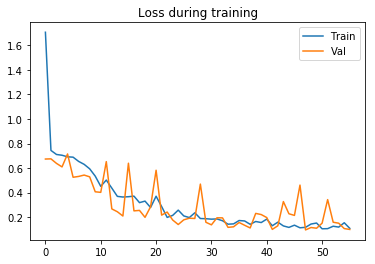

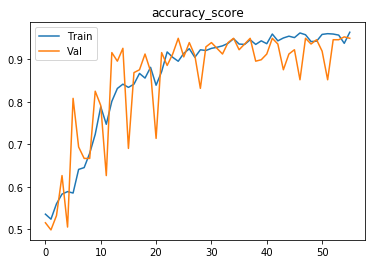

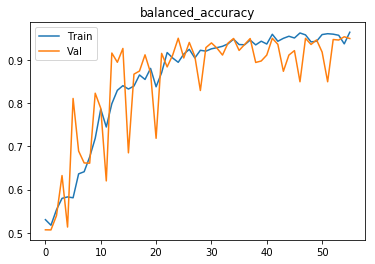

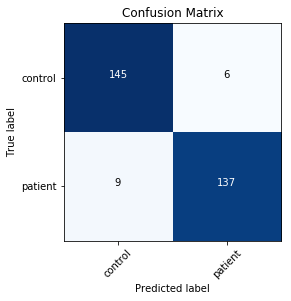

Starting trial 9
[0,    30] loss: 2.81503
[0,    60] loss: 0.72938
[0,    90] loss: 0.75951
Time elapsed: 0h:4m:7s
train accuracy_score: 53.54 %
train balanced_accuracy: 53.00 %
val accuracy_score: 60.61 %
val balanced_accuracy: 59.99 %
Val loss: 0.662106
[1,    30] loss: 0.69808
[1,    60] loss: 0.71567
[1,    90] loss: 0.72528
Time elapsed: 0h:8m:57s
train accuracy_score: 55.99 %
train balanced_accuracy: 55.26 %
val accuracy_score: 50.17 %
val balanced_accuracy: 50.99 %
Val loss: 0.673252
[2,    30] loss: 0.69800
[2,    60] loss: 0.70370
[2,    90] loss: 0.68481
Time elapsed: 0h:13m:27s
train accuracy_score: 56.41 %
train balanced_accuracy: 55.75 %
val accuracy_score: 51.18 %
val balanced_accuracy: 51.99 %
Val loss: 0.667001
[3,    30] loss: 0.65653
[3,    60] loss: 0.65843
[3,    90] loss: 0.70738
Time elapsed: 0h:18m:19s
train accuracy_score: 59.11 %
train balanced_accuracy: 58.81 %
val accuracy_score: 52.53 %
val balanced_accuracy: 51.71 %
Val loss: 0.680446
[4,    30] loss: 0.617

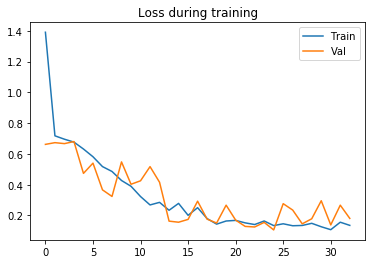

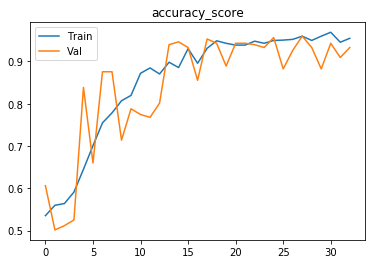

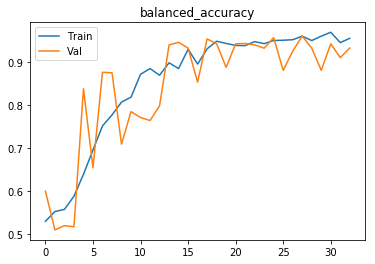

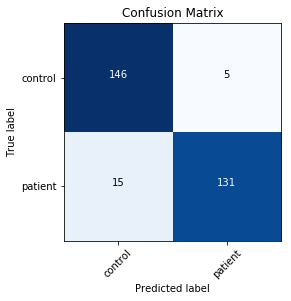

################################
################################
All accuracies: [0.8840152408600198, 0.8974870724848045, 0.9006849315068494, 0.9146103601560375, 0.8186065499410324, 0.9458858749886602, 0.9393767576884696, 0.9302367776467386, 0.9493105325229066, 0.9320738455955729]
0.9112287943391092
0.03724293228908078


In [29]:
fold_metric, models = run(net=net, data=train_df,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=b
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [30]:
5/0

ZeroDivisionError: division by zero

In [ ]:
output_dir = "/analysis/ritter/projects/Methods/Eitel_local_filter/models"

In [ ]:
def save_model(model, full_path):
    print("Writing model to disk...")
    model = model.cpu()
    torch.save(model.state_dict(), full_path)

In [ ]:
save_models = False

In [ ]:
if save_models:
    for i, model in enumerate(models):
        model_dir = os.path.join(output_dir, "adni_baseline_499k_augmentation_copy1_84_acc_trial_{}.h5".format(i))
        save_model(model, model_dir)

# Start inference

In [31]:
if zero_one_normalize:
    ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
else:
    ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([ToTensor()]), mask=mask)
            
test_loader = DataLoader(
            ukb_data_test, batch_size=1, num_workers=1, shuffle=False
)

In [32]:
metrics = []
lr = 1e-5
wd = 1e-3
criterion = nn.BCEWithLogitsLoss().cuda(gpu)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    
for fold, model in enumerate(models):
    print("Fold {}".format(fold))

    all_preds = []
    all_labels = []
    
    net = model.cuda(gpu)
    net.eval()
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]

            img = img.to(torch.device("cuda:" + str(gpu)))

            output = net.forward(img)
            pred = torch.sigmoid(output) >= 0.5
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    #print(all_preds)
    #print(all_labels)
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    print(balanced_acc)
    '''trainer = Trainer(
                net,
                criterion,
                optimizer,
                scheduler=None,
                metrics=metrics,
                callbacks=None,
                device=gpu,
                prediction_type="binary"
            )
    computed_metrics = trainer.evaluate_model(test_loader, metrics=[balanced_accuracy])'''
    net.train()
    metrics.append(balanced_acc)
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics)
print(metrics_df)
print("Balanced accuracy mean {:.2f} %".format(np.mean(metrics_df[0])*100))


Fold 0
0.8676672640382317
Fold 1
0.8598864994026284
Fold 2
0.864516129032258
Fold 3
0.8953703703703704
Fold 4
0.8064516129032258
Fold 5
0.9252389486260454
Fold 6
0.9260752688172043
Fold 7
0.9347670250896056
Fold 8
0.9247461170848268
Fold 9
0.9008363201911589
######## Final results ########
          0
0  0.867667
1  0.859886
2  0.864516
3  0.895370
4  0.806452
5  0.925239
6  0.926075
7  0.934767
8  0.924746
9  0.900836
Balanced accuracy mean 89.06 %
